In [1]:
# fix python imports relative paths issues
%cd ../../

/mnt/asgard2/code/nadim/repo/DIRV-Net


In [2]:
# auto reload imports if they been modified

%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

2024-05-25 20:35:39.503705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from source.model.tools.shape_break_down import ShapeBreakDown
from source.model.tools.operators.warping_operator import warp_images
from source.model.tools.operators.sampling_operator import sample

from source.model.main.pipe_line.pipe_line_data import PipeLineData

from source.framework.main.image_registration import ImageRegistration
from source.framework.main.data_management.data_set_provider import DataSetProvider

from source.framework.settings.whole_config import WholeConfig
from source.framework.settings.enums import (
    DataSets,
    PreProcessingMethod,
    Stages,
    SyntheticFields,
)
from source.framework.settings.synthetic_fields_provider import SyntheticFieldsProvider

from source.framework.tools.plotting_helper import heat_map_drawer
from source.framework.tools.general import calc_statistics, print_object

In [5]:
config = WholeConfig("delete")

config.images_rank = 2
config.data_set = DataSets.PATCHED_256_MONOCHROME_ANHIR
config.image_pre_processing_method = PreProcessingMethod.LOCAL_UNITY_NORMALIZATION
config.convolutional_kernels_count = 24
config.pyramid_levels_count = 2
config.unfoldings_count = 7
config.non_rigid_max_magnitude_range = (5, 6)

config.force_GPU_ID = 0
config.max_used_gpu_memory = None

config.crop_input_dataset_size_to = 10
config.crop_test_dataset_size_to = 50

# config.synthetic_flow_fields = SyntheticFields.NON_RIGID_FIELDS
# config.non_rigid_max_magnitude_range =(0.004, 0.0041)

image_registerer = ImageRegistration(config)


The used GPU (out of 2 GPUs): Quadro RTX 6000	Available GPU Memory: 24.00 Gb.

Session ID: delete
Tensorflow version : 2.10.0


2024-05-25 20:35:43.616385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-25 20:35:43.616662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-25 20:35:43.635770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-25 20:35:43.636063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-25 20:35:43.636421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [6]:
def plot_img(img, title="") -> None:
    heat_map_drawer(
        img,
        title=title,
        display_grid=False,
        display_axis=False,
        title_font_size=None,
        color_map_name=config.images_preview_color_map,
        color_map_min_val=0,
        color_map_max_val=1,
    )
    plt.show()


def plot_img_diff(img, title="") -> None:
    heat_map_drawer(
        img,
        title=title,
        display_grid=False,
        display_axis=False,
        title_font_size=None,
        color_map_name=config.displacements_preview_color_map,
        color_map_min_val=-1,
        color_map_max_val=1,
    )
    plt.show()

2024-05-25 20:35:47.604773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 20:35:47.605767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-25 20:35:47.606060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-25 20:35:47.606285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

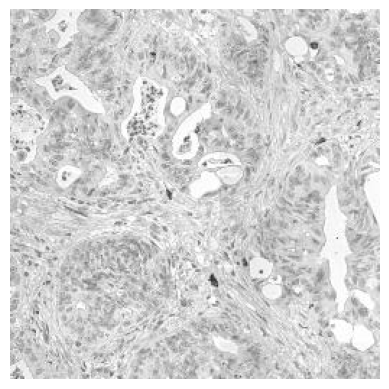

In [7]:
provider = DataSetProvider(config)

moving_images = provider.load_data_set(Stages.TESTING).original_data[48]
moving_images = np.array(Image.open(moving_images).convert("L"))
moving_images = moving_images / np.max(moving_images)

plot_img(moving_images)

moving_images = tf.convert_to_tensor(moving_images, dtype=tf.float32)
moving_images = tf.expand_dims(moving_images, axis=0)
moving_images = tf.expand_dims(moving_images, axis=-1)

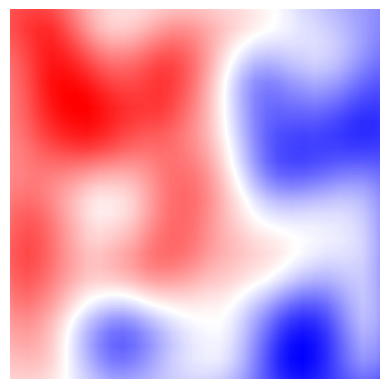

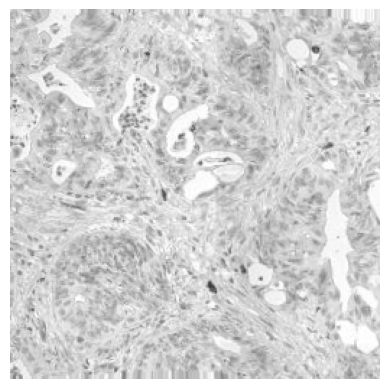

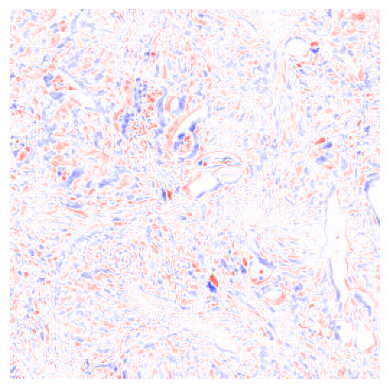

Property                  Value            
------------------------  -----------------
coefficient_of_variation  33415.01770019531
dissimilarity             22.022457        
maximum                   174.2303         
mean                      0.08863886       
minimum                   -186.17532       
size                      65536            
standard_deviation        29.618689        


In [10]:
# config.white_noise_flows_probability = 1

gt_fields, poisoned_gt_fields = SyntheticFieldsProvider(config, Stages.TESTING).generate(
    ShapeBreakDown(moving_images)
)

gt_displacements = sample(gt_fields, config.displacements_control_points_spacings)

fixed_images, _ = warp_images(moving_images, poisoned_gt_fields)

plot_img_diff((gt_fields/tf.reduce_max(gt_fields))[0, ..., 0].numpy())
plot_img(fixed_images[0, ..., 0].numpy())
plot_img_diff((fixed_images - moving_images)[0, ..., 0].numpy())
print_object(calc_statistics((fixed_images - moving_images) * 255))

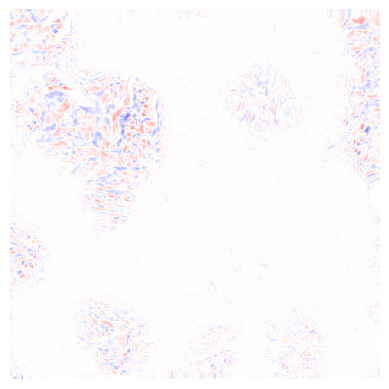

Property                  Value             
------------------------  ------------------
coefficient_of_variation  61713.140869140625
dissimilarity             6.6499357         
maximum                   124.64415         
mean                      0.020889703       
minimum                   -140.99751        
size                      65536             
standard_deviation        12.891692         


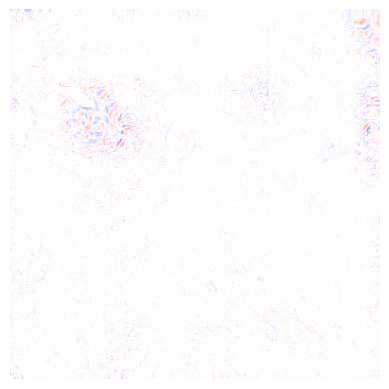

Property                  Value            
------------------------  -----------------
coefficient_of_variation  97587.68310546875
dissimilarity             3.8217542        
maximum                   86.23555         
mean                      0.007097694      
minimum                   -100.38674       
size                      65536            
standard_deviation        6.926475         


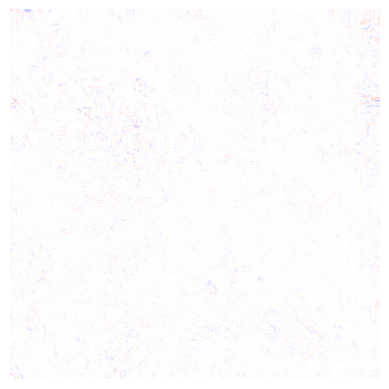

Property                  Value            
------------------------  -----------------
coefficient_of_variation  299515.1123046875
dissimilarity             3.642374         
maximum                   67.848885        
mean                      0.0018250141     
minimum                   -69.05871        
size                      65536            
standard_deviation        5.466193         


In [13]:

max_recurrence_count = 15

VARS_DIR = "output/D8/saved_models/30"

image_registerer.reset()

recurrent_registered_image = moving_images
previews_smaller_max = np.Inf

for i in range(max_recurrence_count):
    results = image_registerer.single_infer(
        VARS_DIR, fixed_images, recurrent_registered_image, gt_displacements, False, False
    )

    registered_image = results[0][-1].pipeline_data.final_variation_unit().registered_images

    stats = calc_statistics((fixed_images - registered_image) * 255)

    # if stats.standard_deviation <= previews_smaller_max:
    #     previews_smaller_max = stats.standard_deviation
    # else:
    #     break

    # if dis <= previews_smaller_max:
    #     previews_smaller_max = dis
    # else:
    #     break

    if stats.dissimilarity <= previews_smaller_max:
        previews_smaller_max = stats.dissimilarity
    else:
        break

    plot_img_diff((fixed_images - registered_image)[0, ..., 0].numpy())
    print_object(stats)

    recurrent_registered_image = registered_image

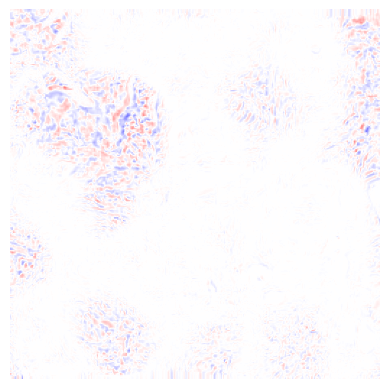

Property                  Value           
------------------------  ----------------
coefficient_of_variation  61690.0634765625
dissimilarity             6.6499376       
maximum                   124.641975      
mean                      0.020897485     
minimum                   -140.99803      
size                      65536           
standard_deviation        12.891672       

approximate loss : 1.0675166845321655



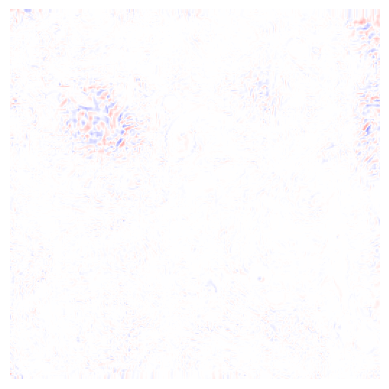

Property                  Value             
------------------------  ------------------
coefficient_of_variation  117083.41064453125
dissimilarity             3.825837          
maximum                   86.33849          
mean                      0.005913442       
minimum                   -100.46651        
size                      65536             
standard_deviation        6.92366           

approximate loss : 0.4893121123313904



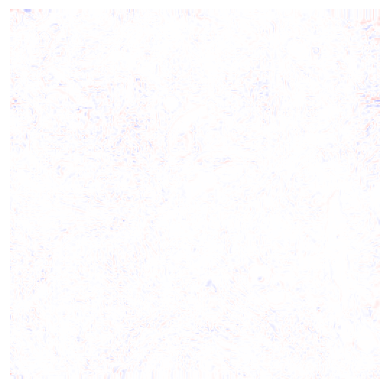

Property                  Value             
------------------------  ------------------
coefficient_of_variation  170713.58642578125
dissimilarity             3.6719918         
maximum                   59.208714         
mean                      0.0032238103      
minimum                   -69.53005         
size                      65536             
standard_deviation        5.5034823         

approximate loss : 0.37315821647644043



In [15]:
VARS_DIR = "output/D8/saved_models/30"

image_registerer.reset()

results= image_registerer.single_infer(
    VARS_DIR, fixed_images, moving_images, gt_displacements, True, False
)

for i in range(len(results[0])):
    result = results[0][i]
    registered_image = result.pipeline_data.final_variation_unit().registered_images

    plot_img_diff((fixed_images - registered_image)[0, ..., 0].numpy())
    print_object(result.statistics)
    print(f"\napproximate loss : {result.pseudo_loss}\n")

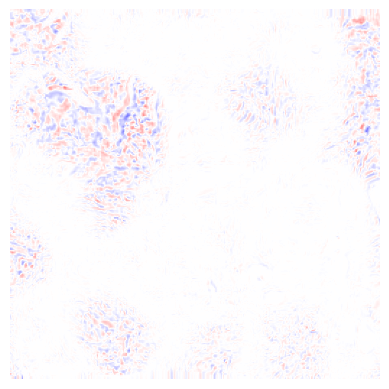

Property                  Value          
------------------------  ---------------
coefficient_of_variation  61702.685546875
maximum                   124.6381       
mean                      0.02089324     
minimum                   -140.99753     
size                      65536          
standard_deviation        12.89169       

approximate loss : 1.0675162076950073



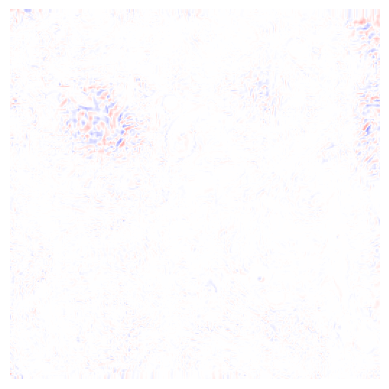

Property                  Value            
------------------------  -----------------
coefficient_of_variation  90844.47631835938
maximum                   86.24558         
mean                      0.007623572      
minimum                   -100.55357       
size                      65536            
standard_deviation        6.925594         

approximate loss : 0.4893321394920349



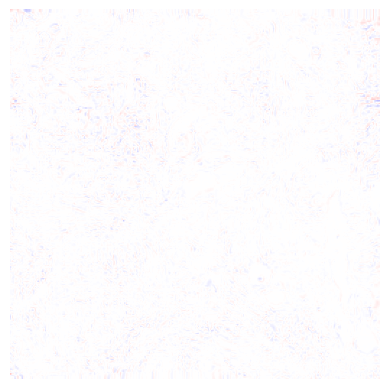

Property                  Value             
------------------------  ------------------
coefficient_of_variation  -67048.05297851562
maximum                   68.563614         
mean                      -0.008120937      
minimum                   -69.00375         
size                      65536             
standard_deviation        5.4449306         

approximate loss : 0.37247151136398315



In [57]:
VARS_DIR = "output/D8/saved_models/30"

image_registerer.reset()

results= image_registerer.single_infer(
    VARS_DIR, fixed_images, moving_images, gt_displacements, True, True
)

for i in range(len(results[0])):
    result = results[0][i]
    registered_image = result.pipeline_data.final_variation_unit().registered_images

    plot_img_diff((fixed_images - registered_image)[0, ..., 0].numpy())
    print_object(result.statistics)
    print(f"\napproximate loss : {result.pseudo_loss}\n")

## white noise max threshold

0.005


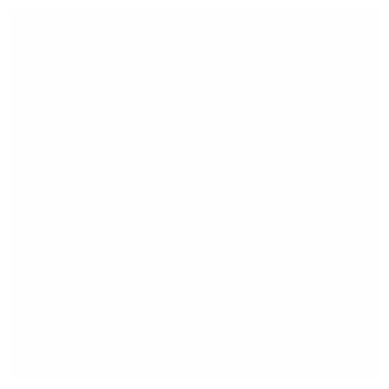

(0.8149347, -0.6629808, -0.00038652107, 0.07996783, 20689.125061035156)


In [96]:
gt_fields = SyntheticFieldsProvider(config, Stages.TESTING).generate(
    ShapeBreakDown(moving_images)
)

THRESHOLD = 0.005

# gt_fields = tf.zeros_like(gt_fields)

noise = np.random.normal(0,1, gt_fields.shape.as_list())
mx = np.max(np.abs(noise))
noise = (noise / mx) * THRESHOLD

print(np.max(np.abs(noise)))

noise =  tf.convert_to_tensor(noise, dtype=tf.float32)

# noise = tf.random.uniform(shape=gt_fields.shape, minval=-THRESHOLD, maxval=THRESHOLD, dtype=tf.float32)

fixed_images1, _ = warp_images(moving_images, gt_fields)
fixed_images2, _ = warp_images(moving_images, gt_fields + noise)

plot_img_diff((fixed_images1 - fixed_images2)[0, ..., 0].numpy())
print(calc_statistics((fixed_images1 - fixed_images2) * 255))

0.005


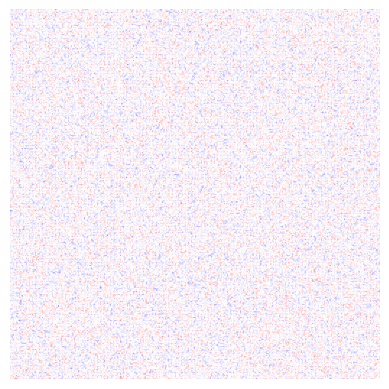

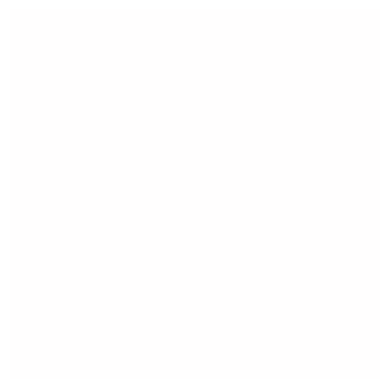

(0.0, 0.0, 0.0, 0.0, nan)


In [13]:
config.white_noise_flows_poison_probability = 0
config.white_noise_flows_replacing_probability = 1

gt_fields, poisoned_gt_fields = SyntheticFieldsProvider(config, Stages.TESTING).generate(
    ShapeBreakDown(moving_images)
)

print (tf.reduce_max(tf.math.abs(gt_fields)).numpy())

fixed_images, _ = warp_images(moving_images, gt_fields)
poisoned_fixed_images, _ = warp_images(moving_images, poisoned_gt_fields)

plot_img_diff((gt_fields[0, ..., 0]*100).numpy())
plot_img_diff((fixed_images - poisoned_fixed_images)[0, ..., 0].numpy())
print(calc_statistics((fixed_images - poisoned_fixed_images) * 255))

# test combined statistics

In [55]:
from source.framework.tools.general import combine_statistics, calc_statistics, print_object

samples_count = 5
samples_size_range = (5, 25)

samples_sets = []
samples_sets_stats = []
all_samples = []

# np.random.seed(9)

for i in range(samples_count):
    samples_set = list(
        np.random.randint(
            low=0,
            high=100,
            size=np.random.randint(
                low=samples_size_range[0], high=samples_size_range[1]
            ),
        )
    )
    all_samples = all_samples + samples_set
    samples_sets.append(samples_set)
    samples_sets_stats.append(calc_statistics(samples_set))

all_stats = calc_statistics(all_samples)

combined_stats = combine_statistics(samples_sets_stats)

print_object(all_stats)
print("\n\n")
print_object(combined_stats)

Property                  Value             
------------------------  ------------------
coefficient_of_variation  64.37462702723047 
maximum                   98                
mean                      45.79012345679013 
minimum                   1                 
size                      81                
standard_deviation        29.477221190617016



Property                  Value             
------------------------  ------------------
coefficient_of_variation  64.37462702723047 
maximum                   98                
mean                      45.79012345679013 
minimum                   1                 
size                      81                
standard_deviation        29.477221190617016
